In [1]:
%matplotlib inline

In [2]:
!pip install wget pysptools 

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



# Classification


Rama K. Vasudevan

* Institute for Functional Imaging of Materials
* Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some imaging data (and simulate some), and perform basic classification analysis, including:
========================================================================================
* Support Vector Machines
* Decision Trees
* Clustering


In [3]:
# Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Plotting and visualization:
import matplotlib.pyplot as plt

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
# finally import pycroscopy:
try:
    import pyUSID as usid
except ImportError:
    print('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid
try:
    import pycroscopy as px
except ImportError:
    print('pycroscopy not found.  Will install with pip.')
    import pip
    install('pycroscopy')
    import pycroscopy as px
    
from pycroscopy.viz import cluster_utils

/Users/rvv/anaconda3/lib/python3.6/site-packages/pycroscopy/__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


# Dataset

The data we will be working with is a STEM image of an oxide catalyst. <br>

The image is courtesy of A. Borisevich (ORNL) and Q. He (Manchester)

The image was processed using a sliding window method, to generate local 2D FFT spectra associated with individual locations within the image. We effectively have a stack of 2D images to analyze, which we can do so using multivariate analysis tools.

In [4]:
data_file_path = '../Data/SuperImage2.h5'

h5_file = h5py.File(data_file_path, mode='r+')

usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-FFT_Window_000
      -----------------------
      ├ FFT_Data
      ├ FFT_Data-Cluster_000
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Cluster_001
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Cluster_002
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Decomposition_000
        --------------------------
        ├ Components
        ├ Position_Indices
        ├ Position_Values
        ├ 

In [5]:
#Get the image
h5_meas_grp = h5_file['Measurement_000']

h5_image =  h5_meas_grp['Channel_000/Raw_Data']

#Convert to USID Dataset
h5_image = usid.USIDataset(h5_image)

# Getting a reference to the main spectral dataset:
h5_main = usid.USIDataset(h5_meas_grp['Channel_000/Raw_Data-FFT_Window_000/FFT_Data'])

print('Data currently of shape:', h5_main.shape)

[num_rows,num_cols] = h5_main.pos_dim_sizes
num_spect = h5_main.spec_dim_sizes[0]


Data currently of shape: (1024, 16384)


1. Support Vector Machines
=====================================

Support Vector Machines are linear classifiers that are easy to understand. Let's start by simulating some data, and then using the SVM implementation in scikit-learn in order to separate the data into two classes.


Text(0.5,1,'Toy Problem')

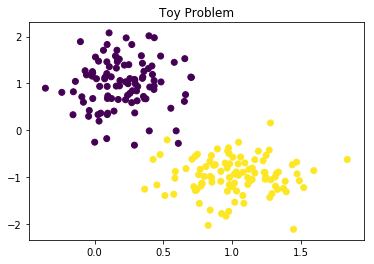

In [6]:
#Generate some random data

X1 = 0.2 + 0.2*np.random.randn(100)
Y1 = 1 + 0.5*np.random.randn(100)

X2 = 1 + 0.3*np.random.randn(100)
Y2 = -1 + 0.4*np.random.randn(100)

class_1 = np.vstack((X1,Y1))
class_2 = np.vstack((X2,Y2))

labels = np.zeros(shape = (class_1.shape[1]+class_2.shape[1]))

#Create a labels vector
labels[:class_1.shape[1]] = 0
labels[class_1.shape[1]:] = 1

all_points = np.hstack((class_1,class_2)) #join all the points together

#Plot it
fig, axes = plt.subplots()
axes.scatter(all_points[0,:], all_points[1,:], c = labels)
axes.set_title('Toy Problem')

In [7]:
all_points.shape

(2, 200)

In [8]:
#We first need to split the data into a set for training and a set for testing. 
#We can do this using the method train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_points.T, labels, test_size=0.25, shuffle = True)

In [9]:
#Let's train an SVM classifier
from sklearn.svm import SVC

C = 1.0 #tradeoff between maximizing the margin vs. mis-classification
        #Making this higher favors smaller margins for reduced mis-classification
    
svc = SVC(kernel = 'linear')
#Fit it to the training data
svc.fit(X_train, y_train)

#Now let's test the classifier
y_pred = svc.predict(X_test)
#Score it
score = svc.score(X_test,y_test)
print('Score: ' + str(score))

Score: 1.0


# Plotting the Decision boundary surface

We can plot the decision boundary using the code below. This code is directly taken from the example in the sklean page, i.e. http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

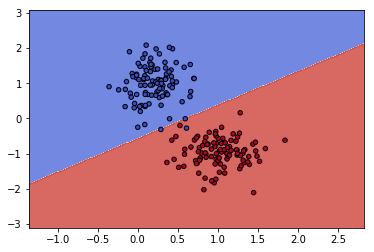

In [10]:

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


xx, yy = make_meshgrid(all_points[0,:], all_points[1,:])

fig, axes = plt.subplots()

plot_contours(axes, svc, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
axes.scatter(all_points[0,:], all_points[1,:], c=labels, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Exercise 

1. Vary the C parameter and see how the decision boundary surface changes.
2. Play with the kernel parameter, and see what effects this has.
3. (Advanced): See if the SVM can be used as a classifier in the earlier FFT example. 

# Decision Trees

Decision trees are nice in that they are easier to interpret than support vector machines. However, they have a tendency towards overfitting, and caution is advised. More advanced versions, such as random forests, can overcome this difficulty eseentially by training many trees (ensemble). Here we will try to apply decision trees on the simulated data once more, to see how it can partition the data in 2D. We will then explore the tree visually.

Text(0.5,1,'Toy Problem')

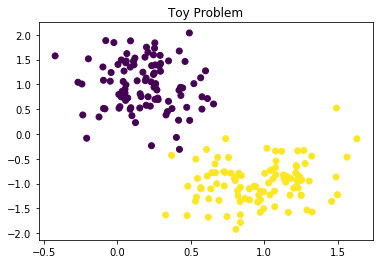

In [11]:
#Generate some random data

X1 = 0.2 + 0.2*np.random.randn(100)
Y1 = 1 + 0.5*np.random.randn(100)

X2 = 1 + 0.3*np.random.randn(100)
Y2 = -1 + 0.4*np.random.randn(100)

class_1 = np.vstack((X1,Y1))
class_2 = np.vstack((X2,Y2))

labels = np.zeros(shape = (class_1.shape[1]+class_2.shape[1]))

#Create a labels vector
labels[:class_1.shape[1]] = 0
labels[class_1.shape[1]:] = 1

all_points = np.hstack((class_1,class_2)) #join all the points together

#Do the test-train split again
X_train, X_test, y_train, y_test = train_test_split(all_points.T, labels, test_size=0.25, shuffle = True)

#Plot it
fig, axes = plt.subplots()
axes.scatter(all_points[0,:], all_points[1,:], c = labels)
axes.set_title('Toy Problem')

In [12]:
#This time, we import the decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#Use entropy as the criterion
dtc = DecisionTreeClassifier(criterion = 'entropy')

#Fit to the training data
dtc.fit(all_points.T, labels)

#Score it
score = dtc.score(X_test, y_test)
print(score)

1.0


Text(0.5,1,'Decision Tree Surface')

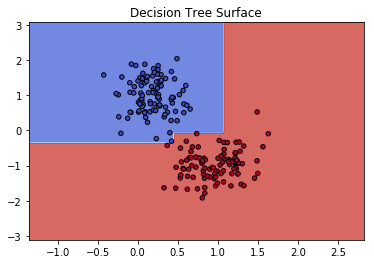

In [13]:
#Now let's plot the decision surface

fig, axes = plt.subplots()

plot_contours(axes, dtc, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
axes.scatter(all_points[0,:], all_points[1,:], c=labels, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axes.set_title('Decision Tree Surface')

In case you don't have the graphviz package, use conda to install it. We reccomend you type this into a terminal (anaconda prompt on windows): <br>

conda install graphviz

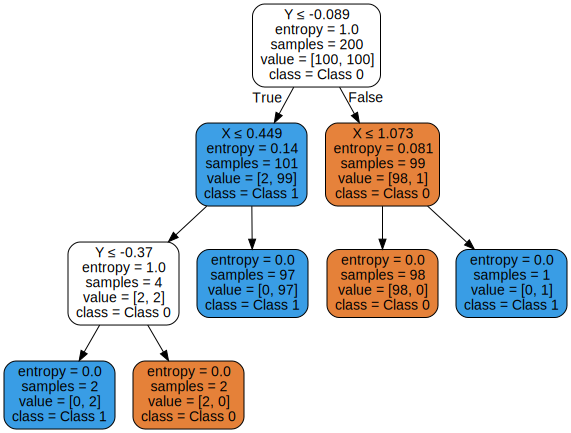

In [14]:
#We can visualize the decision tree using some viz packages. 
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=['X', 'Y'],  
                         class_names=['Class 0', 'Class 1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Exercise

4. Simulate a dataset with three classes, and train both a decision tree and SVM classifier. Draw the decision surface for both classifiers and check which shows higher accuracy.

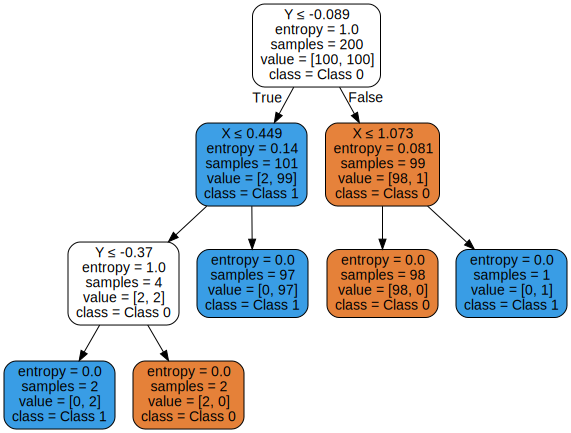

In [15]:
# Bonus - We can even visualize the classifier!
dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=['X', 'Y'],  
                         class_names=['Class 0', 'Class 1', 'Class 2'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# 4. KMeans Clustering
====================

KMeans clustering is a quick and easy method to determine the types of spectral responses present in the
data. It is not a decomposition method, but a basic clustering method. The user inputs the number of
clusters (sets) to partition the data into. The algorithm proceeds to find the optimal labeling
(ie., assignment of each spectra as belonging to the k<sup>th</sup> set) such that the within-cluster
sum of squares is minimized.

Set the number of clusters below



Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Cluster has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Cluster_002" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Cluster_002
set the "override" flag to True to recompute results


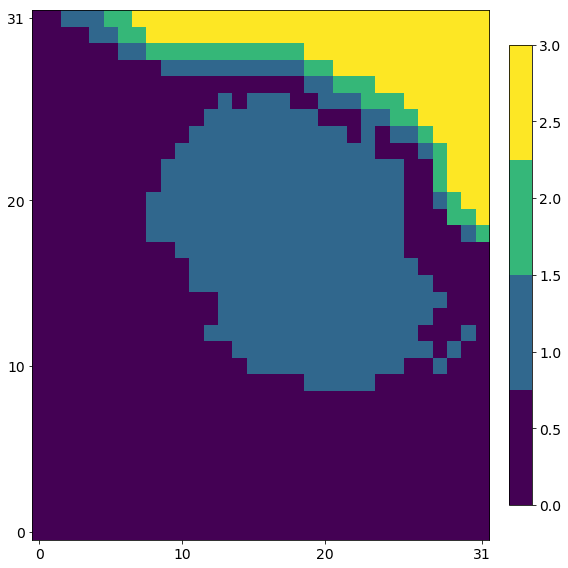

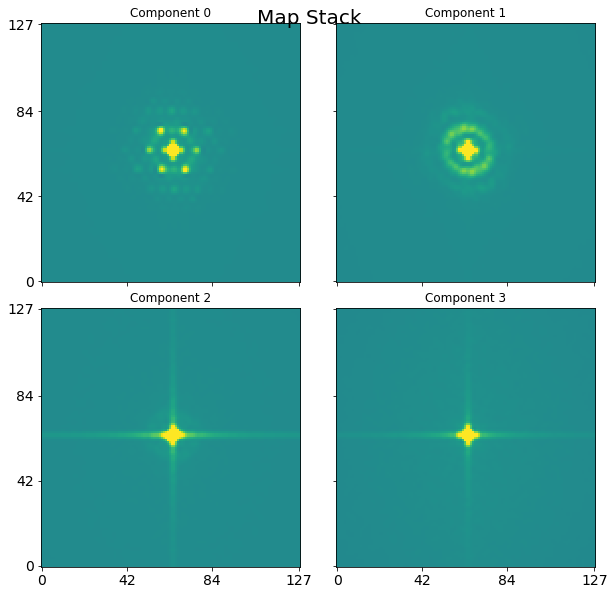

In [16]:
num_clusters = 4

estimator = px.processing.Cluster(h5_main, KMeans(n_clusters=num_clusters))
h5_kmeans_grp = estimator.compute(h5_main)
h5_kmeans_labels = h5_kmeans_grp['Labels']
h5_kmeans_mean_resp = h5_kmeans_grp['Mean_Response']

fig_labels =cluster_utils.plot_cluster_labels(h5_kmeans_labels[:].reshape(num_rows,num_cols),
                                              num_clusters = num_clusters, figsize = (8,8))

fig_centroids =cluster_utils.plot_map_stack(h5_kmeans_mean_resp[:].reshape(num_clusters, h5_main.spec_dim_sizes[0], 
                                                                           h5_main.spec_dim_sizes[1]))


# Close the file

After processing, good practice to close the file. 

In [17]:
h5_file.close()